# Legal Text Classification for CIA

## Models and Experiments: Similarity Measures

In [ ]:
!pip install umap-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv

from functions.source_parsing import *
from zipfile import ZipFile
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from nltk.tokenize import sent_tokenize, word_tokenize
from numpy.linalg import norm
import umap.umap_ as umap

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/janinedevera/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/janinedevera/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.chdir("../..")
os.getcwd()

'/Users/janinedevera/Documents/School/MDS 2021-2023/Thesis/multilabel-legal-text-classification-CIA'

### Preliminaries

In [5]:
# legal text, labeled
text = pd.read_csv("data/01 legal_texts_pipeline_stopwords.csv", index_col=0)
text_labels = pd.read_csv("data/01 legal_texts_with_labels_grouped.csv", index_col=0)

# augmented training set and raw test set
train_df_aug = pd.read_csv("data/01 train_data_augmented.csv", index_col=0)
test_df = pd.read_csv("data/01 test_data.csv", index_col=0)

# definitions
defs = pd.read_csv("data/02 oecd_definitions_stopwords.csv", index_col=0)
defs_grouped = pd.read_csv("data/02 oecd_definitions_stopwords_grouped.csv", index_col=0)

In [52]:
unlabeled = pd.read_csv("data/01 legal_texts_pipeline_stopwords.csv", index_col=0)

In [59]:
new = pd.concat([unlabeled['text_clean'], text_labels['text_clean']], axis=0).reset_index(drop=True)
new_df = pd.DataFrame({'text_clean': new})

In [60]:
new_df['length'] = new_df['text_clean'].apply(lambda x: len(x.split()))

In [62]:
new_df['length'].describe()

count    7023.000000
mean      163.469173
std       382.004903
min         6.000000
25%        30.000000
50%        58.000000
75%       141.000000
max      7116.000000
Name: length, dtype: float64

In [6]:
defs_grouped['Main'] = defs_grouped['Main'].replace('D', 'Others')
defs_grouped

,Main,text_clean,length
0,A,limit the number of supplier lead to the risk ...,833
1,B,regul can affect a supplier 's abil to compet ...,781
2,C,regul can affect supplier behaviour by not onl...,459
3,Others,regul sometim limit choic avail to consum for ...,257


In [7]:
# pre-process text (lemmatization only)
train_df_aug['text_clean'] = preprocess_corpus_keep_stop_words(train_df_aug['Text'])
train_df_aug['text_clean'] = [lemmatize(text) for text in train_df_aug['text_clean']]

test_df['text_clean'] = preprocess_corpus_keep_stop_words(test_df['Text'])
test_df['text_clean'] = [lemmatize(text) for text in test_df['text_clean']]

In [8]:
# create binary_label column
train_df_aug['binary_label'] = train_df_aug['Category_New'].apply(lambda x: 0 if x == "None" else 1)
test_df['binary_label'] = test_df['Category_New'].apply(lambda x: 0 if x == "None" else 1)

In [9]:
train_df_binary = train_df_aug
train_df_binary = train_df_binary.drop_duplicates(subset=('text_clean', 'binary_label'), keep='first')

test_df_binary = test_df
test_df_binary = test_df_binary.drop_duplicates(subset=('text_clean', 'binary_label'), keep='first')

In [10]:
bert_scores_old = pd.read_csv("data/scores/03 sim_scores_bert.csv", index_col=0)
bert_scores = pd.read_csv("data/scores/03 sim_scores_bert_sts.csv", index_col=0)

In [11]:
bert_scores_old['Label_True'] = bert_scores_old['Label'].apply(lambda x: re.sub(r'[^a-zA-Z]', '', x))
bert_scores_old["Label_True"] = bert_scores_old["Label_True"].replace("D", "Others")
bert_scores_old

,Text,Label_Text,Name,Score,Label,Label_True
0,"In public aerodromes, if the operator does not...",when govern deregul introduc market previous e...,D3,0.317244,None,None
1,"In public aerodromes, if the operator does not...",regul make consum le will switch supplier affe...,D2,0.244662,None,None
2,"In public aerodromes, if the operator does not...",regul sometim limit choic avail consum for exa...,D1,0.329156,None,None
3,"In public aerodromes, if the operator does not...",in mani countri particular supplier econom sec...,C3,0.323133,None,None
4,"In public aerodromes, if the operator does not...",regul requir market particip publish inform pr...,C2,0.262859,None,None
...,...,...,...,...,...,...
14143,"In the first five years, share transfer leadin...",regul rais cost entri exit market tend discour...,A4,0.416960,A2,A
14144,"In the first five years, share transfer leadin...",govern limit abil certain supplier particip bu...,A3,0.520037,A2,A
14145,"In the first five years, share transfer leadin...",licens permit requir oper necessarili restrict...,A2,0.487934,A2,A
14146,"In the first five years, share transfer leadin...",grant exclus right produc certain good provid ...,A1,0.497762,A2,A


In [37]:
score_median = bert_scores_old['Score'].median()
score_median_adjusted = score_median 

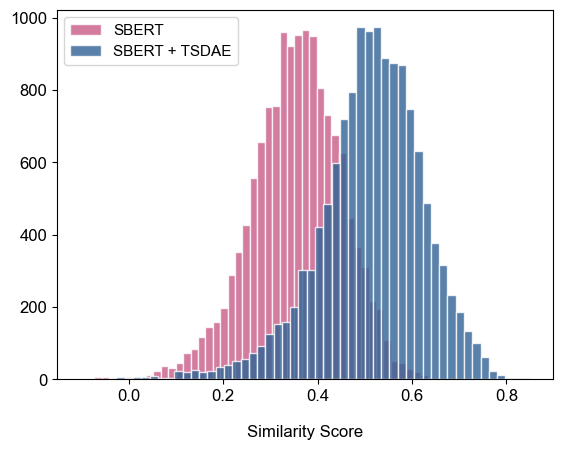

In [13]:
import matplotlib.font_manager as fm

plt.hist(bert_scores_old['Score'], bins=50, edgecolor='white', alpha=0.8, label='SBERT', color = '#C85B89')
plt.hist(bert_scores['Score'], bins=50, edgecolor='white', alpha=0.8, label='SBERT + TSDAE', color = '#306294')

plt.xlabel('Similarity Score', fontname='Arial', fontsize=12, labelpad=15)
#plt.ylabel('Count', fontname='Arial', fontsize=12, labelpad=15)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12, rotation=0)

prop = fm.FontProperties(family='Arial', size=11)
plt.legend(prop=prop)

save_path = os.path.join('draft', 'images', 'plot05-15.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

In [38]:
bert_scores_old = bert_scores_old[bert_scores_old['Label_True'].isin(['A', 'B', 'C', 'Others', "None"])]
bert_scores_old = bert_scores_old[bert_scores_old['Name'] != 'None']
bert_scores_old['Predict'] = np.where(bert_scores_old['Score'] >= score_median-0.03, bert_scores_old['Label_True'], 'None')
bert_scores_old[['Text', 'Score', 'Label_True', 'Predict']].drop_duplicates()

,Text,Score,Label_True,Predict
0,"In public aerodromes, if the operator does not...",0.317244,None,None
1,"In public aerodromes, if the operator does not...",0.244662,None,None
2,"In public aerodromes, if the operator does not...",0.329156,None,None
3,"In public aerodromes, if the operator does not...",0.323133,None,None
4,"In public aerodromes, if the operator does not...",0.262859,None,None
...,...,...,...,...
14143,"In the first five years, share transfer leadin...",0.416960,A,A
14144,"In the first five years, share transfer leadin...",0.520037,A,A
14145,"In the first five years, share transfer leadin...",0.487934,A,A
14146,"In the first five years, share transfer leadin...",0.497762,A,A


In [40]:
report = classification_report(bert_scores_old['Label_True'], bert_scores_old['Predict'])
print(report)

              precision    recall  f1-score   support

           A       1.00      0.65      0.79      7164
           B       1.00      0.86      0.92       702
           C       1.00      0.51      0.67       108
        None       0.69      1.00      0.82      5904
      Others       1.00      0.50      0.67        18

    accuracy                           0.81     13896
   macro avg       0.94      0.70      0.77     13896
weighted avg       0.87      0.81      0.81     13896



In [41]:
def class_report_df(labels, predictions):
    report = classification_report(labels, predictions, zero_division=0, output_dict=True)

    categories = ['A', 'B', 'C', 'Others', 'None']
    metrics = ['precision', 'recall', 'f1-score']
    data = []
    for category in categories:
        row = []
        for metric in metrics:
            row.append(round(report[category][metric], 2))
        data.append(row)

    report_df = pd.DataFrame(data, columns=metrics, index=categories)

    return report_df

In [42]:
report = class_report_df(bert_scores_old['Label_True'], bert_scores_old['Predict'])

In [43]:
def report_heatmap(report_df, file_name, color):
    plt.figure(figsize=(6, 8))
    sns.heatmap(report_df, annot=True, cmap=color, cbar=False, vmin=0, vmax=1,  fmt='.2f',
            annot_kws={"fontfamily": "Arial", "fontsize": 12})
    #plt.xlabel('Metrics', labelpad=12, fontname='Arial', fontsize=12)
    #plt.title('Classification report', fontname='Arial', fontsize=14, y=1.02)
    plt.xticks(fontname='Arial', fontsize=12)
    plt.yticks(fontname='Arial', fontsize=12, rotation=0)
    plt.tick_params(axis='y', length=0)
    plt.tick_params(axis='x', length=0)

    # save the figure
    save_path = os.path.join('draft', 'images', file_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()  


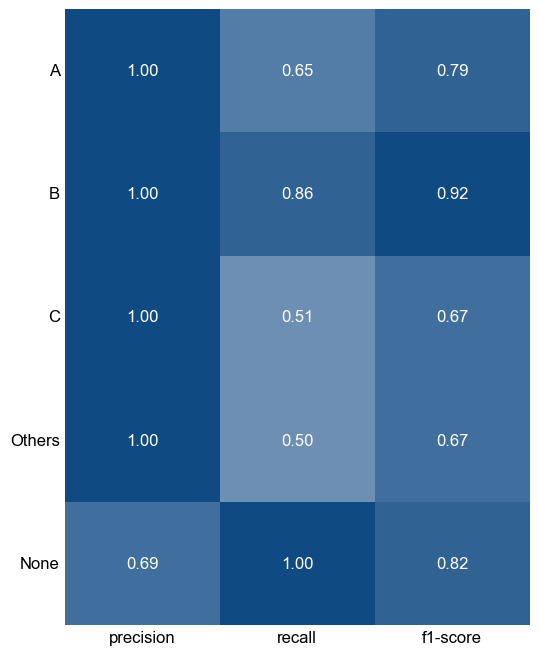

In [44]:
custom_cmap_blues = sns.color_palette(['#A9BBD3', '#A0B4CF', '#8FA8C6', '#7E9CBD', '#6D8FB4', '#537CA6', '#416F9D', '#306294', '#0F4A82'])
report_heatmap(report, 'plot06-03.png', custom_cmap_blues)

In [45]:
score_median = bert_scores['Score'].median()

In [46]:
bert_scores['Predict'] = np.where(bert_scores['Score'] >= score_median, bert_scores['Label_True'], 'None')
bert_scores[['Text', 'Score', 'Label_True', 'Predict']].drop_duplicates()

,Text,Score,Label_True,Predict
0,• articl of the act stipul that the violat of ...,0.620997,B,B
1,• articl of the act stipul that the violat of ...,0.599725,B,B
2,• articl of the act stipul that the violat of ...,0.601265,B,B
3,• articl of the act stipul that the violat of ...,0.752252,B,B
4,articl of the act stipul that a breach of thi ...,0.529027,B,B
...,...,...,...,...
13775,establish subject to thi norm i.e those that m...,0.527197,A,A
13776,the minimum number of pilotag run per semest c...,0.602872,A,A
13777,the minimum number of pilotag run per semest c...,0.527284,A,A
13778,the minimum number of pilotag run per semest c...,0.515223,A,None


In [47]:
report = classification_report(bert_scores['Label_True'], bert_scores['Predict'])
print(report)

              precision    recall  f1-score   support

           A       1.00      0.48      0.65      2460
           B       1.00      0.55      0.71      3540
           C       1.00      0.36      0.53      2584
        None       0.26      1.00      0.42      2084
      Others       1.00      0.57      0.73      2952

    accuracy                           0.57     13620
   macro avg       0.85      0.59      0.61     13620
weighted avg       0.89      0.57      0.62     13620



In [48]:
report = class_report_df(bert_scores['Label_True'], bert_scores['Predict'])

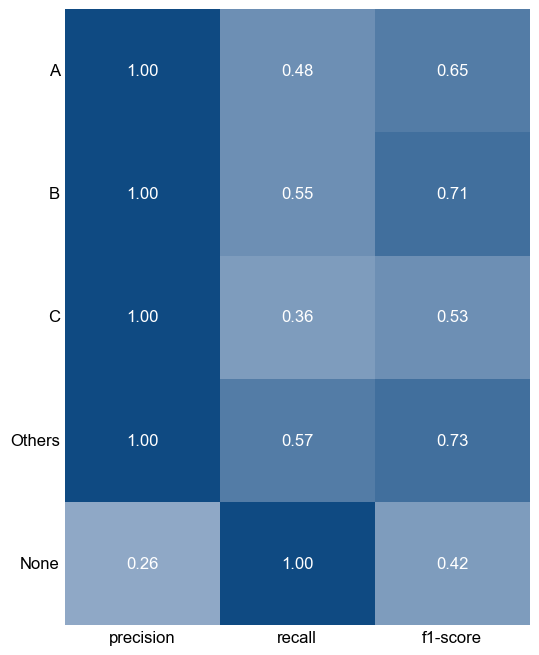

In [49]:
report_heatmap(report, 'plot06-04.png', custom_cmap_blues)

### I. GloVe

##### a. Document embedding matrix

In [ ]:
# load GloVe embeddings
dims = 300
f = open(f'data/glove/glove.6B.{dims}d.txt') # download GloVe and save in data folder

embed_matrix = pd.read_table(
    f, sep = " ", index_col = 0, 
    header = None, quoting = csv.QUOTE_NONE
)

embed_matrix.shape

In [ ]:
# function for doc embeddings
def doc_embed(df, vectorizer):
    dfm = vectorizer.fit_transform(df['text_clean'])
    common_features = set(embed_matrix.index) & set(vectorizer.get_feature_names_out())
    vocab_ids = [vectorizer.vocabulary_[x] for x in common_features]
    matrix = dfm[:,vocab_ids].dot(embed_matrix.loc[common_features,])
    return matrix

In [ ]:
vectorizer = TfidfVectorizer()
countvectorizer = CountVectorizer()

In [ ]:
# doc embeddings for legal text
text_labels_embed = doc_embed(train_df_aug, vectorizer)
text_labels_embed.shape

In [ ]:
# doc embeddings for grouped labels
defs_grouped_embed = doc_embed(defs_grouped, vectorizer)
defs_grouped_embed.shape

##### b. Cosine similarities

In [ ]:
def cos_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

In [ ]:
docs = []
for i in range(len(text_labels_embed)):
    scores = []
    for j in range(len(defs_grouped_embed)):
        A = text_labels_embed[i]
        B = defs_grouped_embed[j]
        scores += [(cos_sim(A,B)+1)/(1+1)] # centered 
    docs += [scores]

In [ ]:
scores_df = pd.DataFrame(docs, columns = ["A", "B", "C", "Others"])
scores_df.head()

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(scores_df.values.flatten(), bins=50, alpha=0.5, fill='#0C6291')
plt.xlabel('Value', fontname='Arial', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontname='Arial', fontsize=12, labelpad=10)
plt.title('Distribution of Scores in All Categories', fontname='Arial', fontsize=14)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12)
plt.show()

In [ ]:
# df with scores
text_scores_labels_glove = pd.merge(train_df_aug, scores_df, left_index=True, right_index=True)
text_scores_labels_glove.to_csv("data/scores/01 sim_scores_glove_labeled.csv")

##### c. Threshold test

In [ ]:
text_scores_labels_glove = pd.read_csv("data/scores/01 sim_scores_glove_labeled.csv", index_col=0)

In [ ]:
df_long = pd.melt(text_scores_labels_glove, id_vars=['Law', 'Text', 'Category',  'Category_New', 'text_clean'], 
                  var_name='Predict_Label', value_name='Score') #scores df to long format 
df_long.head()

In [ ]:
results_multiclass = df_long 
results_multiclass['Predict'] = np.where(results_multiclass['Score'] > 0.90, results_multiclass['Predict_Label'], 'None') #set threshold
results_multiclass[['Law', 'Text', 'text_clean', 'Score', 'Category_New', 'Predict']].drop_duplicates()

In [ ]:
report = classification_report(results_multiclass['Category_New'], results_multiclass['Predict'])
print(report)

In [ ]:
# generate classification report
report = classification_report(results_multiclass['Category_New'], results_multiclass['Predict'], zero_division=0, output_dict=True)

# extract precision, recall, and f1-score for each category
categories = ['A', 'B', 'C', 'Others', 'None']
metrics = ['precision', 'recall', 'f1-score']
data = []
for category in categories:
    row = []
    for metric in metrics:
        row.append(round(report[category][metric], 2))
    data.append(row)

# create dataframe
report_df = pd.DataFrame(data, columns=metrics, index=categories)

In [ ]:
plt.figure(figsize=(6, 8))
sns.heatmap(report_df, annot=True, cmap=custom_cmap_blues, cbar=False, vmin=0, vmax=1,  fmt='.2f',
            annot_kws={"fontfamily": "Arial", "fontsize": 12})
#plt.xlabel('Metrics', labelpad=12, fontname='Arial', fontsize=12)
#plt.title('Classification report', fontname='Arial', fontsize=14, y=1.02)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12, rotation=0)
plt.tick_params(axis='y', length=0)
plt.tick_params(axis='x', length=0)
plt.show()

##### d. Binary threshold test

In [ ]:
results_binary = df_long 
results_max_score = results_binary.groupby('Text')['Score'].max() #get the highest score among 4 categories
results_final = pd.merge(results_binary, results_max_score, on=['Text', 'Score'])

results_final['Predict'] = np.where(results_final['Score'] > 0.90, 'Yes', 'None') #if max score of highest category is above 0.95, predicted label = yes
results_final['Category_New'] = np.where(results_final['Category_New'] == 'None', results_final['Category_New'], 'Yes') #all categories changed to 'yes' except none

In [ ]:
report = classification_report(results_final['Category_New'], results_final['Predict'])
print(report)

##### e. Dimensionality reduction

In [ ]:
# df combining text and labels
df_comb = (text_scores_labels_glove[['Law', 'text_clean', 'Category_New']]
           .rename(columns = {'Law':'name'})
           .append(defs_grouped[['Main', 'text_clean']]
                   .rename(columns = {'Main':'name'})))
df_comb.head()

In [ ]:
reducer = umap.UMAP()

# dfm combining embeddings 
def dfm_combined(df, dfm1, dfm2):
    dfm_comb = np.vstack((dfm1, dfm2))
    embed = reducer.fit_transform(dfm_comb)
    df["x"] = embed[:,0]
    df["y"] = embed[:,1]
    return df

In [ ]:
dfm_reduced = dfm_combined(df_comb, text_labels_embed, defs_grouped_embed)

In [ ]:
dfm_reduced.to_csv("data/scores/02 sim_scores_dim_reduced_glove.csv")

In [ ]:
text_labels_embed_nonaug = doc_embed(text_labels, vectorizer)
text_labels_embed_nonaug.shape

In [ ]:
embed = reducer.fit_transform(text_labels_embed_nonaug)
text_labels["x"] = embed[:,0]
text_labels["y"] = embed[:,1]

In [ ]:
text_labels.to_csv("data/03 word_embed_glove.csv")

### II. Legalw2v

##### a. Document embedding matrix (from SigmaLaw word2vec trained from legal corpus)

In [ ]:
w2v_law = KeyedVectors.load_word2vec_format("data/sigma-lemmatized-legal/legallemmatextreplacewithnnp.bin", binary=True, unicode_errors='ignore') 
w2v_law.vectors.shape

In [ ]:
def doc_matrix_w2v(dfm):
    words = set(vectorizer.get_feature_names_out())
    text_vocab = list(words)

    common_features = []
    for word in text_vocab:
        if word in w2v_law:
            common_features += [word]

    embed_common=np.empty((0,200))
    for word in words:
        if word in w2v_law:
            embed_common=np.vstack([embed_common, w2v_law[word]])

    vocab_ids = [vectorizer.vocabulary_[x] for x in common_features]
    doc_matrix_w2v = dfm[:,vocab_ids].dot(embed_common)

    return doc_matrix_w2v
    

In [ ]:
text_dfm = vectorizer.fit_transform(train_df_aug['text_clean'])
text_doc_matrix = doc_matrix_w2v(text_dfm)
text_doc_matrix.shape

In [ ]:
defs_dfm = vectorizer.fit_transform(defs_grouped['text_clean'])
defs_doc_matrix = doc_matrix_w2v(defs_dfm)
defs_doc_matrix.shape

##### b. Cosine similarities

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(scores_df.values.flatten(), bins=50, alpha=0.5, fill='#0C6291')
plt.xlabel('Value', fontname='Arial', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontname='Arial', fontsize=12, labelpad=10)
plt.title('Distribution of Scores in All Categories', fontname='Arial', fontsize=14)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12)
plt.show()

In [ ]:
# df with scores
text_scores_legalw2v = pd.merge(train_df_aug, scores_df, left_index=True, right_index=True)
text_scores_legalw2v.to_csv("data/scores/01 sim_scores_legalw2v_labeled.csv")

##### c. Threshold test

In [ ]:
df_long = pd.melt(text_scores_legalw2v, id_vars=['Law', 'Text', 'Category',  'Category_New', 'text_clean'], 
                  var_name='Predict_Label', value_name='Score') #scores df to long format 
df_long.head()

In [ ]:
results_multiclass = df_long 
results_multiclass['Predict'] = np.where(results_multiclass['Score'] > 0.70, results_multiclass['Predict_Label'], 'None') #set threshold
results_multiclass[['Law', 'Text', 'text_clean', 'Score', 'Category_New', 'Predict']].drop_duplicates()

In [ ]:
report = classification_report(results_multiclass['Category_New'], results_multiclass['Predict'])
print(report)

In [ ]:
# generate classification report
report = classification_report(results_multiclass['Category_New'], results_multiclass['Predict'], zero_division=0, output_dict=True)

# extract precision, recall, and f1-score for each category
categories = ['A', 'B', 'C', 'Others', 'None']
metrics = ['precision', 'recall', 'f1-score']
data = []
for category in categories:
    row = []
    for metric in metrics:
        row.append(round(report[category][metric], 2))
    data.append(row)

# create dataframe
report_df = pd.DataFrame(data, columns=metrics, index=categories)

In [ ]:
plt.figure(figsize=(6, 8))
sns.heatmap(report_df, annot=True, cmap=custom_cmap_blues, cbar=False, vmin=0, vmax=1,  fmt='.2f',
            annot_kws={"fontfamily": "Arial", "fontsize": 12})
#plt.xlabel('Metrics', labelpad=12, fontname='Arial', fontsize=12)
#plt.title('Classification report', fontname='Arial', fontsize=14, y=1.02)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12, rotation=0)
plt.tick_params(axis='y', length=0)
plt.tick_params(axis='x', length=0)
plt.show()

##### d. Binary threshold test

In [ ]:
results_binary = df_long 
results_max_score = results_binary.groupby('Text')['Score'].max() #get the highest score among 4 categories
results_final = pd.merge(results_binary, results_max_score, on=['Text', 'Score'])

results_final['Predict'] = np.where(results_final['Score'] > 0.70, 'Yes', 'None') #if max score of highest category is above 0.95, predicted label = yes
results_final['Category_New'] = np.where(results_final['Category_New'] == 'None', results_final['Category_New'], 'Yes') #all categories changed to 'yes' except none

In [ ]:
report = classification_report(results_final['Category_New'], results_final['Predict'])
print(report)

##### e. Dimensionality reduction

In [ ]:
dfm_reduced = dfm_combined(df_comb, text_doc_matrix, defs_doc_matrix)

In [ ]:
dfm_reduced.to_csv("data/scores/02 sim_scores_dim_reduced_legal.csv")

Labeled data (not augmented)

In [ ]:
legal_embed_nonaug = vectorizer.fit_transform(text_labels['text_clean'])
legal_dfm = doc_matrix_w2v(legal_embed_nonaug)
legal_dfm.shape

In [ ]:
embed = reducer.fit_transform(legal_dfm)
text_labels["x"] = embed[:,0]
text_labels["y"] = embed[:,1]

In [ ]:
text_labels.to_csv("data/03 word_embed_legal.csv")